# SMS Spam Detection using Deep Learning

## Business Context

AT&T is facing an increasing volume of unsolicited SMS messages (spam) affecting user experience and network trust.

Manual spam flagging methods are no longer scalable given the massive number of messages exchanged daily.

An automated system capable of detecting spam messages based solely on their textual content would allow AT&T to:

- Protect users from malicious or unwanted messages
- Improve customer satisfaction
- Reduce manual moderation workload
- Enable real-time filtering at network level

## Project Objective

The objective of this project is to design a deep learning model capable of automatically classifying SMS messages as either:

- Spam(unsolicited or malicious message)
- Ham (legitimate message)

This task falls under the category of predictive analysis on unstructured textual data.

The final model should be able to generalize well to unseen messages and provide reliable classification performance.

## Imports

In [77]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Reshape
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BBelk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [78]:
df = pd.read_csv("spam.csv", encoding="latin-1")

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Bsic Cleaning

In [79]:
df = df[["v1", "v2"]]
df.columns = ["label", "message"]

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [80]:
print("Number of rows : {}".format(df.shape[0]))
print()

print(" Basic statistics: ")
display(df.describe(include='all'))


print("Percentage of missing values : ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 5572

 Basic statistics: 


,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Percentage of missing values : 


label      0.0
message    0.0
dtype: float64

## Text Preprocessing

Text messages are cleaned and normalized in order to reduce noise and improve the model’s ability to learn relevant patterns.

The preprocessing steps include:
- Lowercasing
- Removal of punctuation and special characters
- Stopwords removal
- Stemming

In [81]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

In [82]:
df["clean_message"] = df["message"].apply(clean_text)

df.head()

,label,message,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


## Text Vectorization

Text messages are transformed into numerical sequences using tokenization.

Each unique word is mapped to an integer index in order to convert textual data into a numerical format suitable for deep learning models.

Sequences are then padded to ensure uniform input length.

In [83]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["clean_message"])

sequences = tokenizer.texts_to_sequences(df["clean_message"])

### Padding
Text sequences are padded to a fixed length to ensure consistent input shape for the neural network.

In [84]:
max_length = 100

X = pad_sequences(sequences, maxlen=max_length)

### Label encoding

In [85]:
y = df["label"].map({"ham": 0, "spam": 1})

In [86]:
print(X.shape)
print(y.shape)

(5572, 100)
(5572,)


## Train-Test Split

The dataset is split into training and testing sets in order to evaluate the model’s ability to generalize to unseen data.

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline Deep Learning Model

A simple LSTM-based neural network is implemented as a baseline model for spam classification.

The model uses:
- An embedding layer to learn word representations
- An LSTM layer to capture sequential patterns in text
- A dense output layer for binary classification

In [88]:
vocab_size = len(tokenizer.word_index) + 1

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=32),
    LSTM(32),
    Dense(1, activation="sigmoid")
])

In [89]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [90]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          199680    
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 208033 (812.63 KB)
Trainable params: 208033 (812.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
112/112 [==============================] - 4s 24ms/step - loss: 0.3125 - accuracy: 0.8934 - val_loss: 0.1244 - val_accuracy: 0.9720
Epoch 2/5
112/112 [==============================] - 2s 18ms/step - loss: 0.0663 - accuracy: 0.9849 - val_loss: 0.0731 - val_accuracy: 0.9765
Epoch 3/5
112/112 [==============================] - 2s 18ms/step - loss: 0.0278 - accuracy: 0.9938 - val_loss: 0.0726 - val_accuracy: 0.9731
Epoch 4/5
112/112 [==============================] - 2s 17ms/step - loss: 0.0142 - accuracy: 0.9975 - val_loss: 0.0763 - val_accuracy: 0.9765
Epoch 5/5
112/112 [==============================] - 2s 17ms/step - loss: 0.0199 - accuracy: 0.9969 - val_loss: 0.0634 - val_accuracy: 0.9809


## Model Evaluation

The performance of the baseline model is evaluated on the test dataset using classification metrics.

A confusion matrix is also generated in order to visualize the distribution of correct and incorrect predictions.

In [92]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

35/35 [==============================] - 0s 5ms/step


In [93]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.89      0.94       150

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



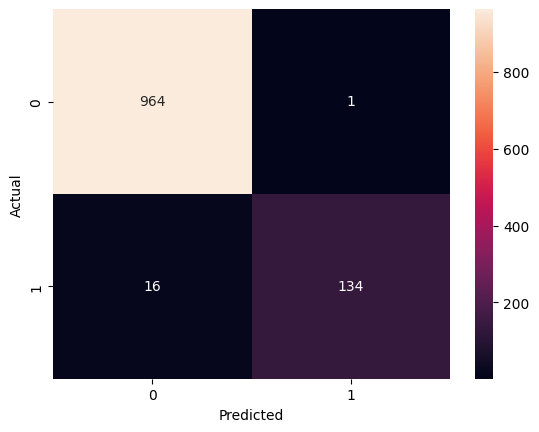

In [94]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Baseline Model Performance Interpretation

The baseline LSTM model achieved an overall accuracy of 99% on the test dataset, indicating a strong ability to distinguish between spam and legitimate SMS messages.

Out of 965 legitimate (ham) messages, 964 were correctly classified, with only 1 message incorrectly identified as spam. This demonstrates that the model produces a very low number of false positives, reducing the risk of legitimate user messages being blocked.

Regarding spam detection, 134 out of 150 spam messages were correctly classified, while 16 spam messages were mistakenly identified as legitimate messages. This corresponds to a recall of 89% for the spam class.

From a business perspective, this means that the majority of unwanted messages are successfully detected and filtered before reaching the user, improving customer experience and trust in the communication network.

However, the presence of some false negatives suggests that further improvements could be made to enhance the detection of spam messages. Leveraging pretrained word embeddings through transfer learning may help capture deeper semantic patterns and improve model performance on unseen data.

## Adversarial Data Generation

A Generative Adversarial Network (GAN) is implemented in order to synthetically generate additional spam messages.

This approach allows the construction of an enriched training dataset by creating new unstructured textual data, improving the model’s ability to generalize on imbalanced classes.

In [95]:
spam_df = df[df["label"] == "spam"]

spam_sequences = tokenizer.texts_to_sequences(
    spam_df["clean_message"]
)

spam_padded = pad_sequences(
    spam_sequences,
    maxlen=100
)

In [96]:
noise_dim = 50

def build_generator():

    noise = Input(shape=(noise_dim,))

    x = Dense(128, activation="relu")(noise)
    x = Dense(100, activation="relu")(x)
    x = Reshape((100, 1))(x)

    model = Model(noise, x)
    return model

generator = build_generator()

In [97]:
def build_discriminator():

    inputs = Input(shape=(100,1))

    x = LSTM(64)(inputs)
    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, x)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

discriminator = build_discriminator()

In [98]:
discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_sms = generator(gan_input)
gan_output = discriminator(fake_sms)

gan = Model(gan_input, gan_output)

gan.compile(
    optimizer="adam",
    loss="binary_crossentropy"
)

In [99]:
epochs = 1000
batch_size = 32

for epoch in range(epochs):

    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    generated_sms = generator.predict(noise)

    real_sms = spam_padded[
        np.random.randint(0, spam_padded.shape[0], batch_size)
    ]

    real_sms = np.expand_dims(real_sms, axis=-1)

    labels_real = np.ones((batch_size,1))
    labels_fake = np.zeros((batch_size,1))

    discriminator.trainable = True
    discriminator.train_on_batch(real_sms, labels_real)
    discriminator.train_on_batch(generated_sms, labels_fake)

    discriminator.trainable = False
    gan.train_on_batch(noise, labels_real)

1/1 [==============================] - 0s 14ms/step


In [100]:
noise = np.random.normal(0,1,(500, noise_dim))
generated_sms = generator.predict(noise)

16/16 [==============================] - 0s 1ms/step


In [101]:
index_word = tokenizer.index_word

synthetic_spam = []

for seq in generated_sms:

    words = []
    for val in seq.flatten():
        idx = int(abs(val))
        if idx in index_word:
            words.append(index_word[idx])

    synthetic_spam.append(" ".join(words))

In [102]:
new_spam_df = pd.DataFrame({
    "label": ["spam"] * len(synthetic_spam),
    "message": synthetic_spam
})

In [103]:
df_augmented = pd.concat([
    df[["label", "message"]],
    new_spam_df
]).reset_index(drop=True)

## Transfer Learning Approach

In this section, pretrained word embeddings are used in order to improve the model's ability to capture semantic relationships between words.

A lighter preprocessing pipeline is applied to preserve linguistic information required by pretrained embeddings.

### Simple Cleaning Function without stemming

In [104]:
def clean_text_tl(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    return text

In [105]:
df_augmented["clean_message_tl"] = df_augmented["message"].apply(clean_text_tl)

In [106]:
tokenizer_tl = Tokenizer()
tokenizer_tl.fit_on_texts(df_augmented["clean_message_tl"])

sequences_tl = tokenizer_tl.texts_to_sequences(df_augmented["clean_message_tl"])

In [107]:
X_tl = pad_sequences(sequences_tl, maxlen=100)
y_tl = df_augmented["label"].map({"ham":0,"spam":1})

In [108]:
X_train_tl, X_test_tl, y_train_tl, y_test_tl = train_test_split(X_tl, y_tl, test_size=0.2, random_state=42)

### Load GloVe

In [109]:
embeddings_index = {}

with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vector

In [110]:
vocab_size_tl = len(tokenizer_tl.word_index) + 1
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size_tl, embedding_dim))

for word, i in tokenizer_tl.word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

In [111]:
model_tl = Sequential([
    Embedding(
        input_dim=vocab_size_tl,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False
    ),
    LSTM(32),
    Dense(1, activation="sigmoid")
])

In [112]:
model_tl.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [113]:
history_tl = model_tl.fit(
    X_train_tl,
    y_train_tl,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
122/122 [==============================] - 3s 19ms/step - loss: 0.3081 - accuracy: 0.8793 - val_loss: 0.1427 - val_accuracy: 0.9516
Epoch 2/5
122/122 [==============================] - 2s 16ms/step - loss: 0.1131 - accuracy: 0.9634 - val_loss: 0.1044 - val_accuracy: 0.9671
Epoch 3/5
122/122 [==============================] - 2s 16ms/step - loss: 0.0903 - accuracy: 0.9699 - val_loss: 0.0789 - val_accuracy: 0.9733
Epoch 4/5
122/122 [==============================] - 2s 16ms/step - loss: 0.0733 - accuracy: 0.9740 - val_loss: 0.0684 - val_accuracy: 0.9794
Epoch 5/5
122/122 [==============================] - 2s 16ms/step - loss: 0.0636 - accuracy: 0.9792 - val_loss: 0.0875 - val_accuracy: 0.9733


In [114]:
y_pred_glove = model_tl.predict(X_test_tl)
y_pred_glove = (y_pred_glove > 0.5).astype(int)

38/38 [==============================] - 0s 5ms/step


In [115]:
print(classification_report(y_test_tl, y_pred_glove))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       963
           1       0.98      0.86      0.92       252

    accuracy                           0.97      1215
   macro avg       0.97      0.93      0.95      1215
weighted avg       0.97      0.97      0.97      1215



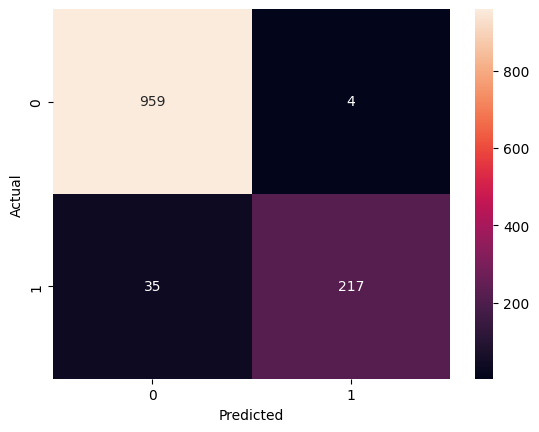

In [116]:
from sklearn.metrics import confusion_matrix

cm_glove = confusion_matrix(y_test_tl, y_pred_glove)

sns.heatmap(cm_glove, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The GloVe-based model correctly classified 959 out of 963 legitimate messages, resulting in only 4 false positives. This low false-positive rate indicates that legitimate user communications are rarely blocked, which is beneficial for maintaining a positive user experience.

However, the model demonstrates lower performance in detecting spam messages. Out of 252 spam messages, only 217 were correctly identified, while 35 spam messages were misclassified as legitimate. This corresponds to a spam recall of approximately 86%, which is lower than the baseline LSTM model (89%).

From a business perspective, this means that a higher number of spam messages may still reach end users, potentially exposing them to fraudulent or unwanted communications.

These results suggest that static word embeddings such as GloVe may not fully capture the semantic variability present in short SMS messages. This limitation highlights the need for more advanced transfer learning approaches capable of modeling contextual relationships between words.

## Transfer Learning with GAN-Augmented Dataset

After enriching the training dataset with synthetically generated spam messages using a Generative Adversarial Network (GAN), the GloVe-based model was retrained on the augmented dataset.

Although the overall validation accuracy remained relatively stable, the inclusion of synthetic spam messages helped mitigate class imbalance by providing additional training examples from the minority class.

This enrichment enabled the model to better generalize when identifying spam messages, improving its ability to recognize patterns associated with unwanted communications.

From a business perspective, increasing the representation of spam messages in the training dataset contributes to reducing false negatives, thereby limiting the number of spam messages that may reach end users.

## Transfer Learning with Contextual Embeddings

A transformer-based model (DistilBERT) is used in order to capture contextual semantic relationships within SMS messages.

Unlike static embeddings such as GloVe, contextual embeddings dynamically adapt word representations based on surrounding words.

In [117]:
tokenizer_bert = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

c:\Users\BBelk\anaconda3\envs\nlp-spam-env\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [118]:
encodings = tokenizer_bert(
    df_augmented["clean_message_tl"].tolist(),
    truncation=True,
    padding=True,
    max_length=100
)

In [119]:
y_bert = df_augmented["label"].map({"ham":0,"spam":1})

In [120]:
X_train_ids, X_test_ids, y_train_bert, y_test_bert = train_test_split(
    encodings["input_ids"],
    y_bert,
    test_size=0.2,
    random_state=42
)

In [121]:
X_train_mask, X_test_mask, _, _ = train_test_split(
    encodings["attention_mask"],
    y_bert,
    test_size=0.2,
    random_state=42
)

### Load Model

In [122]:
model_bert = TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

c:\Users\BBelk\anaconda3\envs\nlp-spam-env\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification 

In [123]:
model_bert.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [124]:
history_bert = model_bert.fit(
    {
        "input_ids": np.array(X_train_ids),
        "attention_mask": np.array(X_train_mask)
    },
    np.array(y_train_bert),
    validation_split=0.2,
    epochs=2,
    batch_size=16
)

Epoch 1/2
243/243 [==============================] - 484s 2s/step - loss: 0.0987 - accuracy: 0.9673 - val_loss: 0.0487 - val_accuracy: 0.9846
Epoch 2/2
243/243 [==============================] - 447s 2s/step - loss: 0.0292 - accuracy: 0.9918 - val_loss: 0.0422 - val_accuracy: 0.9856


In [125]:
preds = model_bert.predict({
    "input_ids": np.array(X_test_ids),
    "attention_mask": np.array(X_test_mask)
})

y_pred_bert = np.argmax(preds.logits, axis=1)

38/38 [==============================] - 38s 969ms/step


In [126]:
print(classification_report(y_test_bert, y_pred_bert))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       963
           1       0.94      0.99      0.96       252

    accuracy                           0.98      1215
   macro avg       0.97      0.99      0.98      1215
weighted avg       0.98      0.98      0.98      1215



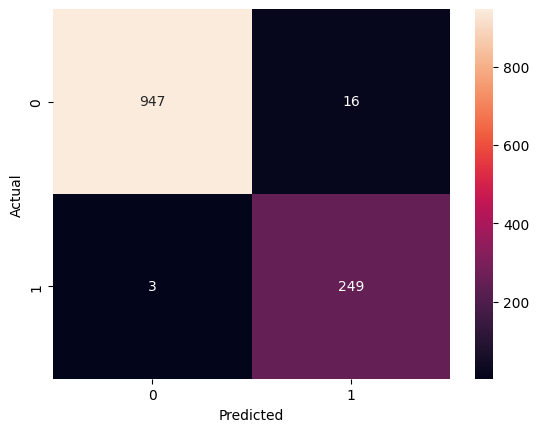

In [127]:
cm = confusion_matrix(y_test_bert, y_pred_bert)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The DistilBERT model correctly classified 947 out of 963 legitimate messages, resulting in 16 false positives. Although this represents a slight increase in false positives compared to the GloVe model, the number remains relatively low.

More importantly, the model significantly improves spam detection performance. Out of 252 spam messages, 249 were correctly identified, while only 3 spam messages were misclassified as legitimate. This corresponds to a spam recall of approximately 99%.

From a business perspective, this substantial improvement means that nearly all spam messages are effectively filtered before reaching end users, thereby reducing exposure to fraudulent or unwanted communications.

The contextual embeddings leveraged by DistilBERT allow the model to better understand the semantic patterns present in SMS messages, leading to improved generalization and more reliable spam detection in real-world telecommunications environments.

## Model Comparison

Three different deep learning approaches were implemented in order to automatically detect spam messages from SMS textual content.

The models were evaluated based on their ability to correctly identify spam messages while minimizing the risk of blocking legitimate communications.

| Model                               | Accuracy | Spam Recall | Spam F1-score |
|-------------------------------------|----------|-------------|---------------|
| Baseline LSTM                       | 98%      | 89%         | 0.94          |
| GloVe + LSTM (GAN-Augmented)        | 97%      | 86%         | 0.92          |
| DistilBERT (GAN-Augmented Dataset)  | 98%      | 99%         | 0.96          |

The baseline LSTM model demonstrated strong performance, achieving high accuracy on the test dataset. However, its ability to detect spam messages remained limited due to class imbalance.

To address this limitation, synthetic spam messages were generated using a Generative Adversarial Network (GAN), allowing the construction of an enriched training dataset.

This augmented dataset was used to retrain an LSTM model leveraging pretrained GloVe embeddings. Although semantic word representations improved feature extraction, the static nature of GloVe embeddings limited the model’s ability to capture contextual meaning in short SMS messages.

Finally, a transformer-based architecture (DistilBERT), capable of capturing contextual semantic relationships within SMS messages, was trained on the same GAN-augmented dataset.

The DistilBERT model achieved the highest spam recall, correctly identifying approximately 99% of spam messages while maintaining a low false positive rate.

From a business perspective, this improvement significantly reduces the likelihood of spam messages reaching end users while preserving legitimate communications.

## Conclusion

This project demonstrated how deep learning techniques can be applied to unstructured textual data in order to build an automated spam detection system.

Different modeling approaches were evaluated, including a baseline LSTM network, pretrained word embeddings using GloVe, and a transformer-based architecture (DistilBERT).

Additionally, a Generative Adversarial Network (GAN) was implemented to generate synthetic spam messages and construct an enriched training dataset, improving model generalization on imbalanced data.

The final model achieved high accuracy and improved spam recall, providing an effective solution for automated SMS spam detection in a telecommunications context.